## Example : DepthSeriesKmeans 

### Import packages, open dataset

In [8]:
import matplotlib.pyplot as plt
from aglio.geo_points.datasets import EarthChem
import aglio
from aglio.seismology.collections import DepthSeriesKMeans

vs_file = "IRIS/wUS-SH-2010_percent.nc"
ds = aglio.open_dataset(vs_file)


### extract profiles

In [ ]:
P = ds.aglio.get_profiles("dvs")

### group the profiles with a `DepthSeriesKmeans` model

The `DepthSeriesKMeans` is the the sci-kit learn `TimeSeriesKmeans` applied to our depth profiles. To use it, you initially instantiate with our `ProfileCollection`, `P` and the number of clusters we want to use to fit our model:

In [ ]:
model = DepthSeriesKMeans(P, n_clusters=3)


after fitting,

In [ ]:
model.fit()

we can extract a GeoDataFrame containing the labels of each of latitude/longitude points:

<Axes: >

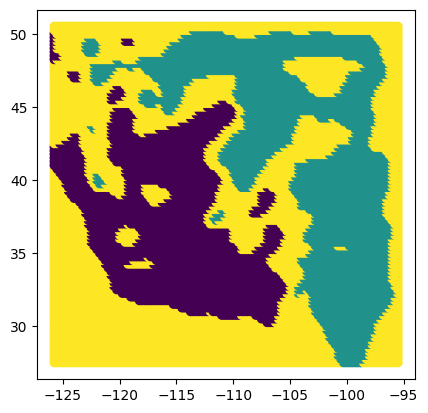

In [21]:
df = model.get_classified_coordinates()
df.plot("labels")

alternatively, we can extract the bounding polygons of the domains and plot it:

<Axes: >

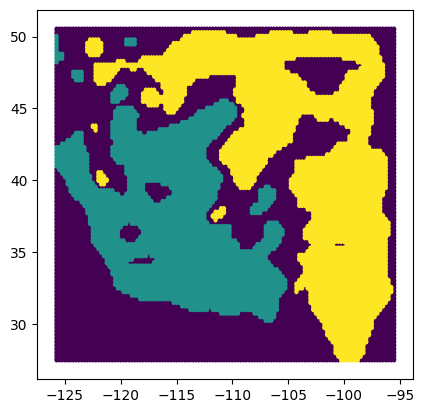

In [19]:
bounds = model.bounding_polygons
bounds.plot('label')

Additionally, you can plot the bounding polygons individually:

<Axes: >

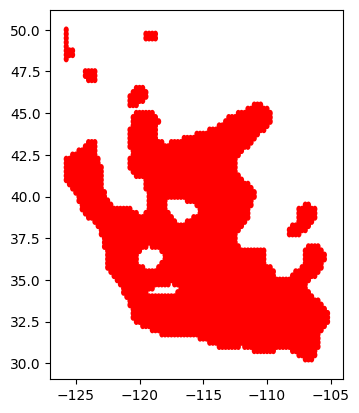

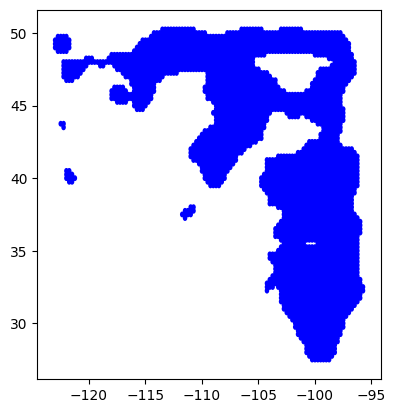

In [42]:
bounds[bounds.label==1].plot(color=(1,0,0,1))
bounds[bounds.label==2].plot(color=(0,0,1,1))

in addition to extracting classified coordinates, you can extract representative profiles and statistics for each label:

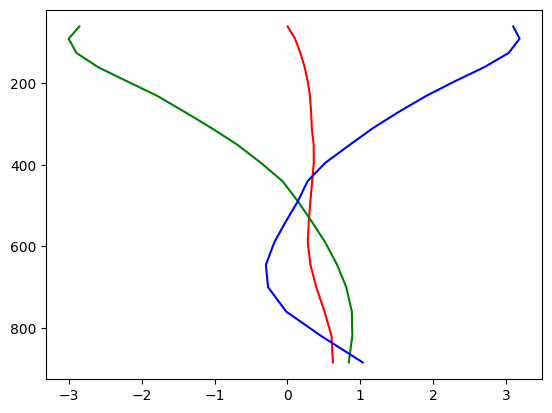

In [6]:
kmeans_stats = model.depth_stats()
plt.figure()
c = ["r", "g", "b", "c", "m"]
for i in range(model.n_clusters):
    minvals = kmeans_stats[i]["two_sigma_min"]
    maxvals = kmeans_stats[i]["two_sigma_max"]
    plt.plot(model.cluster_centers_[i, :], model.profile_collection.depth, color=c[i])
plt.gca().invert_yaxis()
plt.show()

### Determining number of clusters

There are a number of heuristics for determining the optimal number of clusters to use when data into clusters. One such heuristic, is identifying an inflection the model **inertia**, a measure of how well data is divided between groups. As the number of clusters increases, **inertia** will decrease to the limit of very data point being its own cluster. 

The `DepthSeriesKMeans` provides a function, `multi_kmeans_fit` that will cycle through a cluster range, resulting in a suite of models from which you can plot the inertia vs number of clusters. 

First, set a range and then call `multi_kmeans_fit`:

In [4]:
c_range = range(1, 11)
models, inertia = model.multi_kmeans_fit(c_range)

Now, plotting the inertia, we can identify 3 as the inflection point

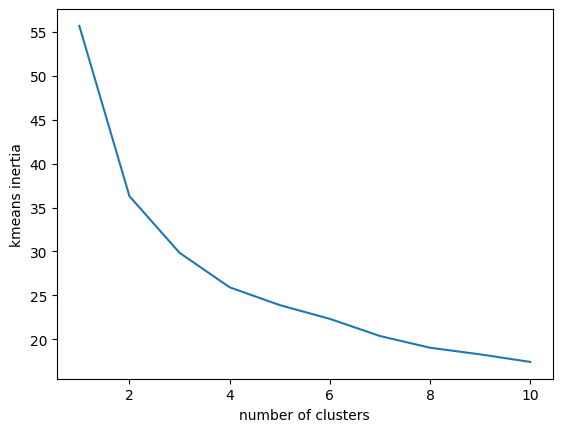

In [5]:
plt.figure()
plt.plot(c_range, inertia)
plt.xlabel("number of clusters")
plt.ylabel("kmeans inertia")
plt.show()


### Statitics from other datasets in classified regions

You can also use the `model_classify_points` to identify the label for **any** GeoDataFrame. For example, lets load up a record of volcanism in the Western United States from the EarthChem database:

In [29]:
file = "data/earthchem/earthchem_download_90561.csv"
echem = EarthChem(file, drop_duplicates_by=["latitude", "longitude", "age"], use_neg_lons=True)

and sort our new data into the labels based solely on latitude/longitude:

In [30]:
df_e = model.classify_points(echem.df)

our dataframe will now have a `labels` column corresponding to the labels calculated in our initial model:

In [39]:
df_e.columns

Index(['sample_id', 'IGSN', 'source', 'reference', 'cruise_id', 'latitude',
       'longitude', 'loc_prec', 'age_min', 'age', 'age_max', 'material',
       'type', 'composition', 'rock_name', 'mineral', 'SIO2', 'geometry',
       'index_right', 'label'],
      dtype='object')

and we easily check out statistics of EarthChem dataset within each label by selecting a label. In the following, we plot histograms of volcanic age in each domain:

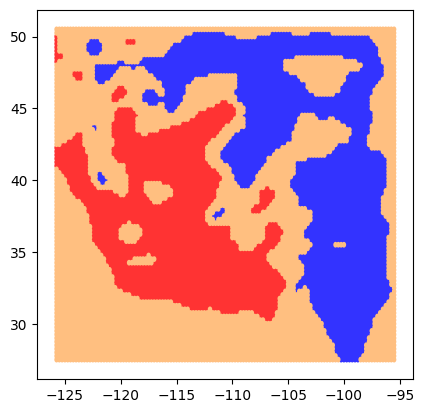

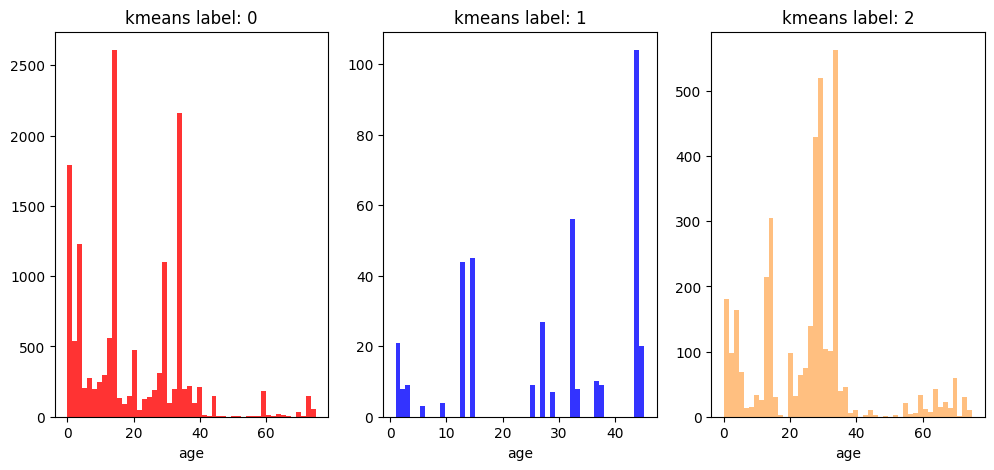

In [40]:
colors = [
    (1.0, 0.2, 0.2, 1.0),
    (0.2, 0.2, 1.0, 1.0),
    (1.0, 0.75, 0.5, 1.0),    
]

fig, ax = plt.subplots(1)
model.bounding_polygons.plot(ax=ax, color=colors)

fig = plt.figure(figsize=(12, 5))
for iclust in range(model.n_clusters):
    plt.subplot(1, model.n_clusters, iclust + 1)
    plt.hist(df_e[df_e.label == iclust].age, bins=50, color=colors[iclust])
    plt.xlabel("age")
    plt.title(f"kmeans label: {iclust}")
plt.show()